<a href="https://colab.research.google.com/github/josefernandezest98/training/blob/main/Depth_Images/depth_stereo_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depth in Stereo Images

The goal consists of getting a complete depth map from stereo images, using the data collected by the accelerometer and the gyroscope. I would like to do it with epipolar geometry and an own method supplying the SIFT.

## Libraries

In [11]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

## Functions

In [12]:
# function: show image with MatPlotLib
def mostrar_img(image):
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.imshow(img2,cmap='gray')
        plt.show()

## Image Download

In [13]:
!wget https://raw.githubusercontent.com/josefernandezest98/training/main/Depth_Images/IMG-8614.jpg # left image
!wget https://raw.githubusercontent.com/josefernandezest98/training/main/Depth_Images/IMG-8613.jpg # right image

--2023-09-16 19:02:20--  https://raw.githubusercontent.com/josefernandezest98/training/main/Depth_Images/IMG-8614.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2580170 (2.5M) [image/jpeg]
Saving to: ‘IMG-8614.jpg.1’

IMG-8614.jpg.1      100%[===================>]   2.46M  --.-KB/s    in 0.04s   

2023-09-16 19:02:21 (57.2 MB/s) - ‘IMG-8614.jpg.1’ saved [2580170/2580170]

--2023-09-16 19:02:21--  https://raw.githubusercontent.com/josefernandezest98/training/main/Depth_Images/IMG-8613.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 O

## OpenCV SIFT

In [14]:
MIN_MATCH_COUNT = 40
img1 = cv.imread('IMG-8614.jpg', cv.IMREAD_GRAYSCALE) # queryImage
img2 = cv.imread('IMG-8613.jpg', cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
    if  len(good)>MIN_MATCH_COUNT:
        break
print("len "+str(len(good)))
if len(good)>MIN_MATCH_COUNT:
    print("1")
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    #print(M)
    #print("mask")
    #print(mask)
    matchesMask = mask.ravel().tolist()
    print("matchesMask")
    print(matchesMask)
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    print("pts")
    print(pts)
    dst = cv.perspectiveTransform(pts,M)
    print("dst")
    print(dst)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,1, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

len 41
1
matchesMask
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
pts
[[[   0.    0.]]

 [[   0. 4031.]]

 [[3023. 4031.]]

 [[3023.    0.]]]
dst
[[[2600.8567 1468.8619]]

 [[2676.3623 1346.0543]]

 [[2547.3958 1520.6924]]

 [[-578.2717 5279.0947]]]


Plotting matches between both stereo images.

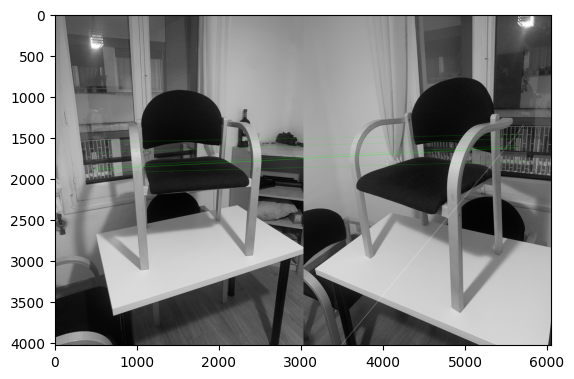

(<matplotlib.image.AxesImage at 0x7c04c1882260>, None)

In [15]:
# Plot matches
plt.imshow(img3, 'gray'),plt.show()

Plotting disparity map, not depth map.

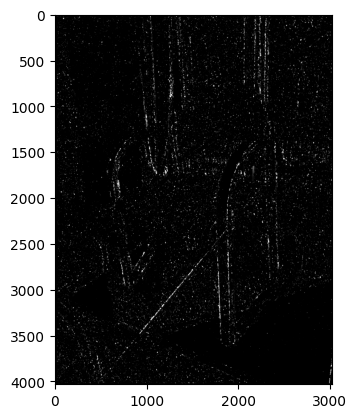

In [16]:
# Plot disparities
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(img1,img2)
plt.imshow(disparity,'gray')
plt.show()



---

